##이중분류

In [0]:
# # 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
# import tensorflow as tf

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

In [0]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np
np.random.seed(777)

In [0]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (waning)

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
!pip install numpy==1.16.2

# 1. 데이터 준비

In [0]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [62]:
from tensorflow.keras.datasets import imdb
import numpy as np

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

TypeError: ignored

In [5]:
sample_idx = 4
print(train_data[sample_idx])

[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 14, 20, 56, 33, 2401, 18, 457, 88, 13, 2626, 1400, 45, 3171, 13, 70, 79, 49, 706, 919, 13, 16, 355, 340, 355, 1696, 96, 143, 4, 22, 32, 289, 7, 61, 369, 71, 2359, 5, 13, 16, 131, 2073, 249, 114, 249, 229, 249, 20, 13, 28, 126, 110, 13, 473, 8, 569, 61, 419, 56, 429, 6, 1513, 18, 35, 534, 95, 474, 570, 5, 25, 124, 138, 88, 12, 421, 1543, 52, 725, 6397, 61, 419, 11, 13, 1571, 15, 1543, 20, 11, 4, 2, 5, 296, 12, 3524, 5, 15, 421, 128, 74, 233, 334, 207, 126, 224, 12, 562, 298, 2167, 1272, 7, 2601, 5, 516, 988, 43, 8, 79, 120, 15, 595, 13, 784, 25, 3171, 18, 165, 170, 143, 19, 14, 5, 7224, 6, 226, 251, 7, 61, 113]


In [6]:
print(train_labels[sample_idx])

0


In [7]:
word_index = imdb.get_word_index() # 특정 단어를 하나의 정수 인덱스로 매핑해놓은 딕셔너리
reverse_word_index = dict([(v,k) for (k, v) in word_index.items()]) # {단어: 정수} => {정수: 단어}로 저장 

# 벡터화 된 문장을 텍스트로 디코딩
# 0, 1, 2번째 단어는 '패딩', '문서 시작', '사전에 없음'을 뜻하는 기호임
decoded_review = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[sample_idx]])
print(decoded_review)

? worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the ? and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life


# 2. 데이터 전처리

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # 결과를 저장할 0 행렬 생성
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1 # 문장에 존재하는 단어들만 one-hot encoding
    return results

# 문장들을 일정한 크기의 벡터로 변환
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

In [0]:
# 리스트 형태인 레이블을 벡터로 변환
y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')

In [10]:
print(X_train[0])

[0. 1. 1. ... 0. 0. 0.]


In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000, 10000)
(25000,)
(25000, 10000)
(25000,)


In [0]:
X_valid = X_train[:10000]
X_train = X_train[10000:]
y_valid = y_train[:10000]
y_train = y_train[10000:]

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(15000, 10000)
(15000,)
(10000, 10000)
(10000,)
(25000, 10000)
(25000,)


# 3. 네트워크 정의

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 4. 모델 컴파일

In [0]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# 5. 모델 학습

In [16]:
history = model.fit(X_train, 
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_valid, y_valid))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 116us/sample - loss: 0.4761 - acc: 0.8181 - val_loss: 0.3399 - val_acc: 0.8823
Epoch 2/20
15000/15000 [==============================] - 1s 85us/sample - loss: 0.2599 - acc: 0.9111 - val_loss: 0.2812 - val_acc: 0.8899
Epoch 3/20
15000/15000 [==============================] - 1s 85us/sample - loss: 0.1851 - acc: 0.9375 - val_loss: 0.2729 - val_acc: 0.8929
Epoch 4/20
15000/15000 [==============================] - 1s 85us/sample - loss: 0.1424 - acc: 0.9526 - val_loss: 0.3063 - val_acc: 0.8796
Epoch 5/20
15000/15000 [==============================] - 1s 85us/sample - loss: 0.1127 - acc: 0.9634 - val_loss: 0.3161 - val_acc: 0.8862
Epoch 6/20
15000/15000 [==============================] - 1s 85us/sample - loss: 0.0885 - acc: 0.9725 - val_loss: 0.3384 - val_acc: 0.8826
Epoch 7/20
15000/15000 [==============================] - 1s 86us/sample - loss: 0.0700 - acc: 0.9800 - val_loss: 0

# 6. 학습 과정 확인

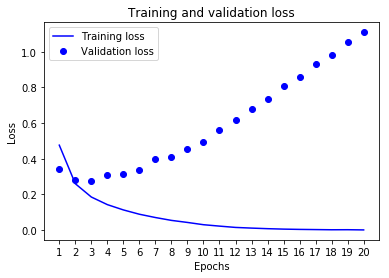

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss') # 'b'는 파란색 실선을 의미
plt.plot(epochs, val_loss, 'bo', label='Validation loss') # 'bo'는 파란색 점을 의미
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

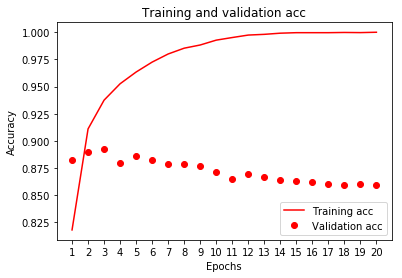

In [18]:
import matplotlib.pyplot as plt


acc, val_acc = history.history['acc'], history.history['val_acc']
epochs = range(1, len(loss)+1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

plt.show()

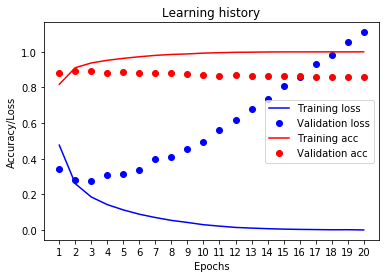

In [19]:
import matplotlib.pyplot as plt

loss, val_loss = history.history['loss'], history.history['val_loss']
acc, val_acc = history.history['acc'], history.history['val_acc']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Learning history')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test loss(20 epochs): ', test_loss)
print('test acc(20 epochs): ', test_acc)

25000/25000 [==============================] - 2s 89us/sample - loss: 1.1725 - acc: 0.8434
test loss(20 epochs):  1.1725323298931123
test acc(20 epochs):  0.84336


# 7. (과대적합 되기 전까지) 모델 학습

In [23]:
# 기존 model 객체를 사용하면 이어서 학습되므로, 새로운 model 객체를 생성함
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

callback_list = [EarlyStopping(monitor='val_loss', patience=3),
                ModelCheckpoint(filepath='model.h5',
                                monitor='val_loss')]

history = model.fit(X_train, 
                    y_train,
                    epochs=13,
                    batch_size=256,
                    validation_data=(X_valid, y_valid),
                    callbacks=callback_list
                    )

Train on 15000 samples, validate on 10000 samples
Epoch 1/13
15000/15000 [==============================] - 2s 117us/sample - loss: 0.4417 - acc: 0.8181 - val_loss: 0.3174 - val_acc: 0.8776
Epoch 2/13
15000/15000 [==============================] - 1s 89us/sample - loss: 0.2361 - acc: 0.9175 - val_loss: 0.2965 - val_acc: 0.8807
Epoch 3/13
15000/15000 [==============================] - 1s 87us/sample - loss: 0.1690 - acc: 0.9409 - val_loss: 0.2896 - val_acc: 0.8849
Epoch 4/13
15000/15000 [==============================] - 1s 88us/sample - loss: 0.1292 - acc: 0.9573 - val_loss: 0.3229 - val_acc: 0.8779
Epoch 5/13
15000/15000 [==============================] - 1s 88us/sample - loss: 0.1008 - acc: 0.9663 - val_loss: 0.3726 - val_acc: 0.8728
Epoch 6/13
15000/15000 [==============================] - 1s 85us/sample - loss: 0.0797 - acc: 0.9730 - val_loss: 0.3627 - val_acc: 0.8794


In [24]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')
print('>> model load!!')

>> model load!!


In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test loss(3 epochs): ', test_loss)
print('test acc(3 epochs): ', test_acc)

25000/25000 [==============================] - 2s 98us/sample - loss: 0.3946 - acc: 0.8636
test loss(3 epochs):  0.3945629805421829
test acc(3 epochs):  0.86364


# 8. 학습된 모델로 새로운 데이터 예측

In [23]:
# 여러 개 동시에 예측
result = model.predict(X_test)
print(result)

print()

# 하나씩 개 동시에 예측
sample = X_test[0]
result = model.predict(np.expand_dims(sample, axis=0))
print(result)

[[0.17264456]
 [0.99933493]
 [0.76177377]
 ...
 [0.06212124]
 [0.06446928]
 [0.37314355]]

[[0.17264456]]


In [0]:
result = model.predict_classes(X_test)

In [25]:
result

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

##다중분류

# 1. 데이터 준비

In [0]:
#!pip install numpy==1.16.2

In [27]:
from tensorflow.keras.datasets import reuters


(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


In [28]:
from tensorflow.keras.datasets import reuters

import numpy as np

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

TypeError: ignored

In [29]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [30]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

# 2. 데이터 전처리

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

In [32]:
train_labels

array([ 3,  4,  3, ..., 25,  3, 25])

In [33]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

Using TensorFlow backend.


In [34]:
one_hot_train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

# 3. 네트워크 정의

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

# 4. 모델 컴파일

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. 모델 학습

In [38]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 114us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 67us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 0s 63us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 63us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 64us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 64us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 0s 62us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020
Epoch 

# 6. 학습 과정 확인

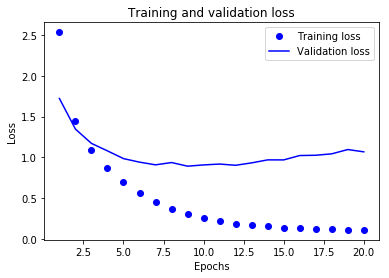

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 7. (과대적합 되기 전까지)모델 학습

In [40]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 93us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 63us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 0s 63us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 64us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 0s 62us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 1s 63us/step - loss: 0.5124 - acc: 0.8921 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 1s 63us/step - loss: 0.4124 - acc: 0.9139 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8/9
7982

# 8. 학습된 모델로 새로운 데이터 예측

In [0]:
predictions = model.predict(x_test)

In [42]:
predictions[0].shape

(46,)

In [43]:
np.sum(predictions[0])

0.9999998

In [44]:
np.argmax(predictions[0])

3

# sparse_categorical_crossentropy

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

# 충분히 큰 층을 두어야 하는 이유

In [46]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 105us/step - loss: 3.1696 - acc: 0.2433 - val_loss: 2.6142 - val_acc: 0.2740
Epoch 2/20
7982/7982 [==============================] - 1s 70us/step - loss: 2.0606 - acc: 0.5461 - val_loss: 1.7033 - val_acc: 0.5860
Epoch 3/20
7982/7982 [==============================] - 1s 71us/step - loss: 1.5012 - acc: 0.6233 - val_loss: 1.5122 - val_acc: 0.6390
Epoch 4/20
7982/7982 [==============================] - 1s 68us/step - loss: 1.2887 - acc: 0.6907 - val_loss: 1.4120 - val_acc: 0.6780
Epoch 5/20
7982/7982 [==============================] - 1s 69us/step - loss: 1.1457 - acc: 0.7159 - val_loss: 1.3673 - val_acc: 0.6830
Epoch 6/20
7982/7982 [==============================] - 1s 71us/step - loss: 1.0403 - acc: 0.7313 - val_loss: 1.3424 - val_acc: 0.6980
Epoch 7/20
7982/7982 [==============================] - 1s 68us/step - loss: 0.9587 - acc: 0.7422 - val_loss: 1.3388 - val_acc: 0.7010
Epoch 